# Machine Learning in Spark

Credits: Content from [apache Spark website](https://spark.apache.org/docs/latest/ml-pipeline.html) and [Machine Learning with PySpark](https://github.com/Apress/machine-learning-with-pyspark) by Pramod Singh (Apress, 2019)

* MLlib is a package baked into Spark that does gathering, cleaning,feature engineering and all that good stuff
* Scalability is the advantage of Spark's ML packages
* Keywords include Tranformers, estimators and Pipelines
* A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
* An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
* Pipeline combines Transformers and Estimators to specify a ML workflow

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [3]:
iris=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)

In [4]:
iris.count()

150

In [7]:
iris.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [9]:
iris.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [10]:
iris.orderBy('petal_width').show(5,False)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|4.9         |3.1        |1.5         |0.1        |setosa |
|4.8         |3.0        |1.4         |0.1        |setosa |
|4.3         |3.0        |1.1         |0.1        |setosa |
|5.2         |4.1        |1.5         |0.1        |setosa |
|4.9         |3.1        |1.5         |0.1        |setosa |
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [13]:
iris.select('species').distinct().show()

+----------+
|   species|
+----------+
| virginica|
|versicolor|
|    setosa|
+----------+



In [15]:
iris.groupBy('species').count().orderBy('count',ascending=False).show()

+----------+-----+
|   species|count|
+----------+-----+
| virginica|   50|
|versicolor|   50|
|    setosa|   50|
+----------+-----+



In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [6]:
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')

In [7]:
final_data = vec_assembler.transform(iris)

In [8]:
final_data.show()

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|
|         5.4|        3.9|         1.7|        0.4| setosa|[5.4,3.9,1.7,0.4]|
|         4.6|        3.4|         1.4|        0.3| setosa|[4.6,3.4,1.4,0.3]|
|         5.0|        3.4|         1.5|        0.2| setosa|[5.0,3.4,1.5,0.2]|
|         4.4|        2.9|         1.4|        0.2| setosa|[4.4,2.9,1.4,0.2]|
|         4.9|        3.1|         1.5|        0.1| setosa|[4.9,

In [31]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)

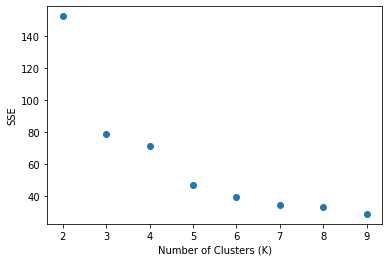

In [32]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [33]:
kmeans = KMeans(featuresCol='features',k=3,)

In [34]:
model = kmeans.fit(final_data)

In [35]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   39|
|         0|   61|
+----------+-----+



In [36]:
predictions=model.transform(final_data)

In [37]:
predictions.columns


['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [39]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
48,5.3,3.7,1.5,0.2,setosa,"[5.3, 3.7, 1.5, 0.2]",1
41,4.5,2.3,1.3,0.3,setosa,"[4.5, 2.3, 1.3, 0.3]",1
121,5.6,2.8,4.9,2.0,virginica,"[5.6, 2.8, 4.9, 2.0]",0
57,4.9,2.4,3.3,1.0,versicolor,"[4.9, 2.4, 3.3, 1.0]",0
7,5.0,3.4,1.5,0.2,setosa,"[5.0, 3.4, 1.5, 0.2]",1


In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

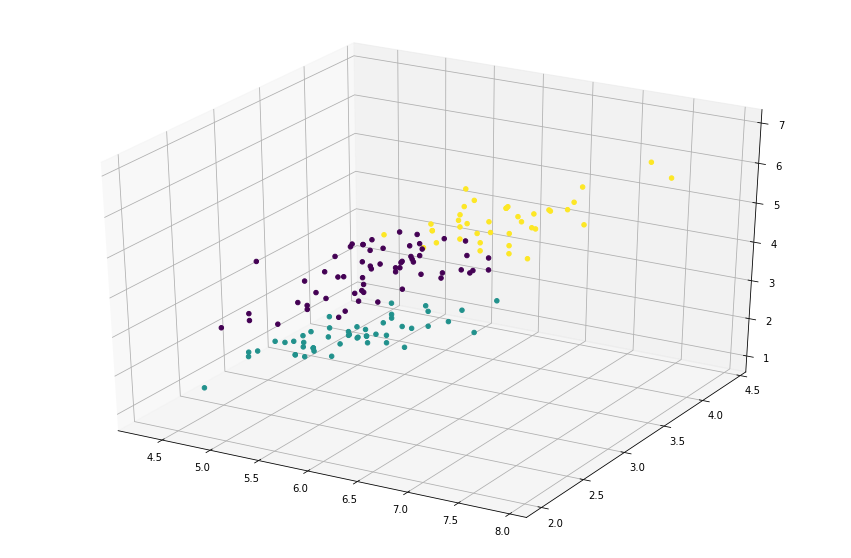

In [41]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()